In [89]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score # para a exibição da acurácia do modelo
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score # função para validação cruzada
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


## Carregando Dados de treino e teste

In [90]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

## Modelo Random Forest


In [91]:
B_model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=0)

# Transcrevendo dados não numéricos
O modelo Random Forest só trabalha com variáveis numéricas. Desse modo, ao analisarmos nosso dataset, fica evidente que necessitamos manipular a coluna datetime, a fim de transcrever as informações de data e hora em formato string para um formato numérico. Assim, o primeiro passo é dividir a coluna datetime em duas colunas filhas: date e time. Para tal, foram definidas as funções splitDate e splitTime.

In [92]:
def splitDate(value):
    return value.split(" ")[0]
def splitTime(value):
    return value.split(" ")[1]


train["date"] = train["datetime"].map(splitDate)
train["time"] = train["datetime"].map(splitTime)

test["date"] = test["datetime"].map(splitDate)
test["time"] = test["datetime"].map(splitTime)

train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,time
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,00:00:00
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01,01:00:00
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01,02:00:00
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01,03:00:00
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01,04:00:00


Uma vez com os dados de data e hora separados, podemos extrair as informações individuais de dia, mês e ano

In [93]:
from datetime import datetime

def getWeekDay(value):
    value = datetime.strptime(value, "%Y-%m-%d").strftime('%A')

    if value == "Sunday":
        return 0
    elif value =="Monday":
        return 1
    elif value =="Tuesday":
        return 2
    elif value =="Wednesday":
        return 3
    elif value =="Thursday":
        return 4
    elif value =="Friday":
        return 5
    elif value == "Saturday":
        return 6

def getYear(value):
    value = int(datetime.strptime(value, "%Y-%m-%d").strftime('%Y'))
    return value

def getMonth(value):
    value = int(datetime.strptime(value, "%Y-%m-%d").strftime('%m'))
    return value

def getDay(value):
    value = int(datetime.strptime(value, "%Y-%m-%d").strftime('%d'))
    return value

dateFunctions = [getWeekDay, getYear, getMonth, getDay]
dateColumns = ["weekday", "year", "month", "day"]

for i in range(len(dateFunctions)):
    train[dateColumns[i]] = train["date"].map(dateFunctions[i])
    test[dateColumns[i]] = test["date"].map(dateFunctions[i])

train.drop('date', inplace=True, axis=1)
test.drop('date', inplace=True, axis=1)

train.head()


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,time,weekday,year,month,day
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,00:00:00,6,2011,1,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,01:00:00,6,2011,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,02:00:00,6,2011,1,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,03:00:00,6,2011,1,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,04:00:00,6,2011,1,1


De maneira análoga, extraíremos as informações mais relevantes referentes ao horário. Note que informações minuto e segundo são pouco impactantes para o treinamento do modelo. Em contrapartida, a informação de bicicletas alugadas durante as horas do dia pode ser bastante descritiva para o cenário em questão:

In [94]:
def getHour(value):
    value = int(datetime.strptime(value,  "%H:%M:%S").strftime('%H'))
    return value

    
train["hour"] = train["time"].map(getHour)
test["hour"] = test["time"].map(getHour)

train.head(100)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,time,weekday,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,00:00:00,6,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,01:00:00,6,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,02:00:00,6,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,03:00:00,6,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,04:00:00,6,2011,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2011-01-05 04:00:00,1,0,1,1,9.84,11.365,48,15.0013,0,2,2,04:00:00,3,2011,1,5,4
96,2011-01-05 05:00:00,1,0,1,1,9.02,11.365,47,11.0014,0,3,3,05:00:00,3,2011,1,5,5
97,2011-01-05 06:00:00,1,0,1,1,8.20,9.850,47,15.0013,0,33,33,06:00:00,3,2011,1,5,6
98,2011-01-05 07:00:00,1,0,1,1,7.38,9.090,43,12.9980,1,87,88,07:00:00,3,2011,1,5,7


# Analisando a distribuição de aluguél das bicicletas em função das variáveis temporais

## Bikes alugadas vs Hora

<AxesSubplot:xlabel='hour', ylabel='count'>

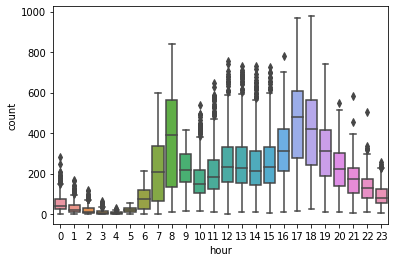

In [95]:
sns.boxplot(x = "hour",y="count",data=train)

## Bikes alugadas vs Dia

<AxesSubplot:xlabel='day', ylabel='count'>

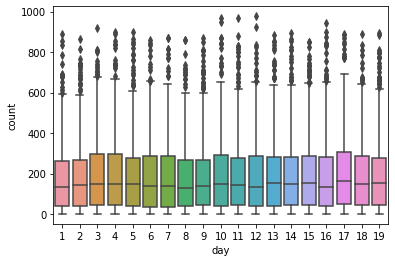

In [96]:
sns.boxplot(x = "day",y="count",data=train)

## Bikes alugadas vs Mês

<AxesSubplot:xlabel='month', ylabel='count'>

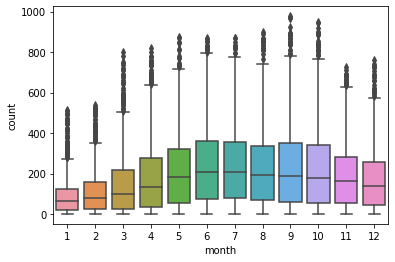

In [97]:
sns.boxplot(x = "month",y="count",data=train)

## Bikes alugadas vs Ano

<AxesSubplot:xlabel='year', ylabel='count'>

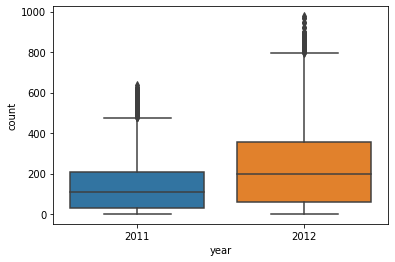

In [98]:
sns.boxplot(x = "year",y="count",data=train)

## Bikes alugadas vs Dia da semana

<AxesSubplot:xlabel='weekday', ylabel='count'>

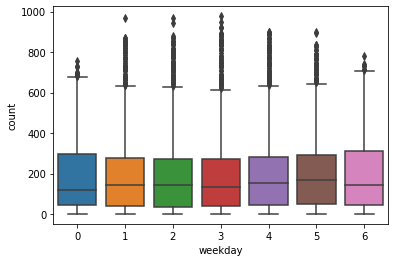

In [99]:
sns.boxplot(x = "weekday",y="count",data=train)

## Bikes alugadas vs Dia útil

<AxesSubplot:xlabel='workingday', ylabel='count'>

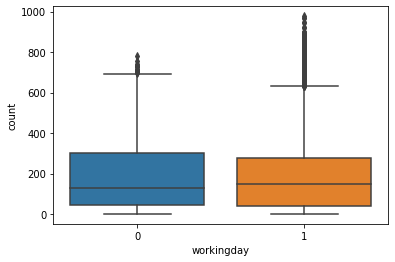

In [100]:
sns.boxplot(x = "workingday",y="count",data=train)

## Observações a partir das variáveis temporais
1. Aumento dos aluguéis de bikes no ano de 2012
2. Aluguel de bikes é maior em dias úteis
3. Aluguel de bikes é maior em horários específicos do dia (7h, 8h, 17h e 18h)

# Analisando a distribuição de aluguél das bicicletas em função das variáveis climáticas

## Bikes alugadas vs Estação do Ano

<AxesSubplot:ylabel='count'>

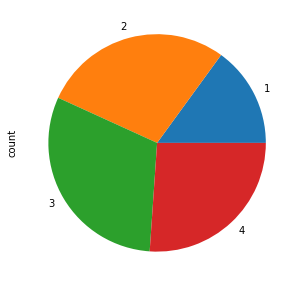

In [101]:
plt.figure(figsize=(5,5))
train.groupby(["season"])["count"].sum().plot.pie()
# 1 = Inverno
# 2 = Outono
# 3 = Verão
# 4 = Primavera

## Bikes alugadas vs Clima

<AxesSubplot:ylabel='count'>

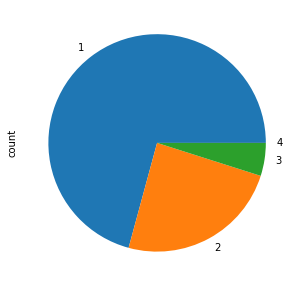

In [102]:
plt.figure(figsize=(5,5))
train.groupby(["weather"])["count"].sum().plot.pie()
# 1 = Limpo a nublado
# 2 = Tempo de Neblina
# 3 = Chuvas Leves
# 4 = Chuvas pesada / Neve

## Bikes alugadas vs Sensação térmica

<AxesSubplot:xlabel='atemp'>

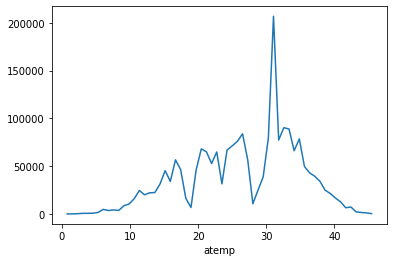

In [103]:
train.groupby("atemp")["count"].sum().plot()

## Observações a partir das variáveis temporais
1. Aluguel de bikes é praticamente nulo em dias de chuvas pesadas / neve
2. Aluguel de bikes é claramente maior em dias com clima limpo e agradável
3. Aluguel de bikes é maior no verão e na primavera
4. Aluguel de bikes é maior quando a sensação térmica está em torno de 30°C

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,weekday,year,month,day,hour,period
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,6,2011,1,1,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,6,2011,1,1,1,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,6,2011,1,1,2,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,6,2011,1,1,3,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,6,2011,1,1,4,0


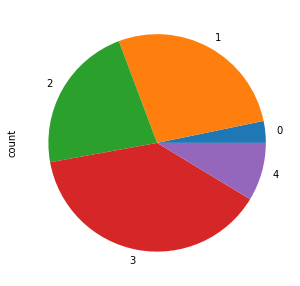

In [104]:
def getDayPeriod(value):
    value = int(datetime.strptime(value,  "%H:%M:%S").strftime('%H'))
    if value <= 5:
        return 0
    elif value >= 6 and value <= 11:
        return 1
    elif value >= 12 and value <= 15:
        return 2
    elif value >= 16 and value <= 20:
        return 3
    elif value >= 21:
        return 4

train["period"] = train["time"].map(getDayPeriod)
test["period"] = test["time"].map(getDayPeriod)

plt.figure(figsize=(5,5))
train.groupby(["period"])["count"].sum().plot.pie()

train.drop('time', inplace=True, axis=1)
test.drop('time', inplace=True, axis=1)

train.head()

In [106]:
j = []
models = [train, test]
for type in models:
    j.clear()
    for i in type["temp"].iteritems() :
        if i[1] < 10:
            x = 0
            j.append(x)

        elif i[1] > 10 and i[1] < 20:
            x = 1
            j.append(x)
        elif i[1] > 20 and i[1] < 30:
            x = 2
            j.append(x)
        else:
            x = 3
            j.append(x)

    type["faixa_temp"] = j

train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,weekday,year,month,day,hour,period,faixa_temp
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,6,2011,1,1,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,6,2011,1,1,1,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,6,2011,1,1,2,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,6,2011,1,1,3,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,6,2011,1,1,4,0,0


# Melhores Correlações:
 temp,atemp,faixa_temp
 season
 period, Hour, Month 

In [109]:
treino_2 = train[["count","period","faixa_temp","hour","month"]]
treino_2.head()

,count,period,faixa_temp,hour,month
0,16,0,0,0,1
1,40,0,0,1,1
2,32,0,0,2,1
3,13,0,0,3,1
4,1,0,0,4,1


In [110]:
treino_2.corr()

,count,period,faixa_temp,hour,month
count,1.000000,0.388080,0.386511,0.400601,0.166862
period,0.388080,1.000000,0.139657,0.974018,-0.007194
faixa_temp,0.386511,0.139657,1.000000,0.149553,0.264189
hour,0.400601,0.974018,0.149553,1.000000,-0.006818
month,0.166862,-0.007194,0.264189,-0.006818,1.000000


<AxesSubplot:xlabel='period', ylabel='count'>

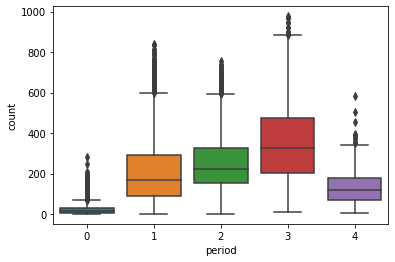

In [111]:
sns.boxplot(x = "period",y="count",data=train)


<AxesSubplot:xlabel='faixa_temp', ylabel='count'>

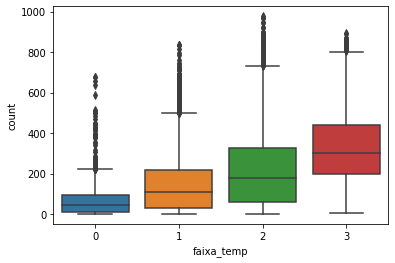

In [112]:
sns.boxplot(x = "faixa_temp",y="count",data=train)
# maior contagem conforme maior a temperatura

In [113]:
#["season","holiday","workingday","weather","temp","atemp","humidity","windspeed","count","weekend","period"]
features = [ "faixa_temp","period", "season", "hour", "month", "holiday", "workingday", "weather", "humidity"]

x_treino = train[features]
y_treino = train["count"]

x_teste = test[features]


In [120]:
P = B_model.fit(x_treino, y_treino)
prev = B_model.predict(x_teste)
prev

array([ 23,  22,   4, ..., 188, 106,  27], dtype=int64)

In [121]:
from os.path import exists
import os
outputPath = "result_model.csv"

file_exists = exists(outputPath)
if file_exists:
    os.remove(outputPath)

sub = pd.Series(prev, index=test["datetime"], name="count")
sub.to_csv(outputPath, header=True)

# test.head()
# P = B_model.fit(x_treino,y_treino)
# previsao = B_model.predict(x_treino)

# print('Pontuacao com dados de Treinamento: ',cross_val_score(P,x_treino,y_treino,cv=2))

In [116]:
# LModel = LinearRegression()
# L = LModel.fit(X=x_treino,y=y_treino)

# print('Pontuacao com dados de Treinamento: ',cross_val_score(L,x_treino,y_treino,cv=2))

In [117]:
# # Outro modelo para testar
# B_model = SVC(gamma="auto")
# P = B_model.fit(x_treino,y_treino)
# previsao = B_model.predict(x_treino)

# print('Pontuacao com dados de Treinamento: ',cross_val_score(P,x_treino,y_treino,cv=2))